# Аспектный анализ тональности текстов

* [1] https://github.com/nlpub/pymystem3
* [2] SentiRuEval2015
* [3] https://rusvectores.org/ru/models/

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

## Оригинальная разметка

Рассмотрим задачу анализа тональности текстов на примерах отзывов об автомобилях, и для этого мы будем использовать датасет, который предлагался участникам соревнования SentiRuEval-2015[1]. У нас есть оригинальный XML-файл с размеченными отзывами об автомобилях, поделённый на training-часть и test-часть, по 200 отзывов в каждом. Содержимое этих файлов выглядит следующим образом: в отзыве присутствует разметка, в которой выделены ключевые слова в тексте, означающие позитивную, нейтральную или негативную оценку. Например, "просторный багажник" — это пример позитивной оценки в отзыве об автомобиле. А такие слова, как "руль закрывает обзор" — это явно негативная часть отзыва. Также, помимо тональности, у нас есть аспекты — категории, которые упомянуты в отзыве. Посмотрим, как они выглядят. Помимо тональной разметки в датасете также содержится аспектная разметка. Проще говоря, в отзывах есть некие аспекты или категории, о которых написан отзыв, например — "общее впечатление" об автомобиле, "надёжность", "стоимость", "управляемость", "внешний вид", "комфорт". На основе оригинальной разметки к данному датасету мы подготовили BIO-разметку, чтобы размеченный таким образом датасет можно было подавать на вход нашей нейросети. Как можно видеть на двух примерах на экране, мы добавили тэг "OTHER" для всех слов, которые не относятся к аспектам или тональности, объединили в сущности, стоящие рядом. Результат вы видите сами. Мы выделили все куски текста, которые были вне оригинальной разметки (например, вот эти два), также (в этих кусках) сделали деление на слова и, наконец, добавили BIO-тэги размеченных в оригинале элементов. А, как вы помните, BIO-тэг — это b — beginning (начало), i — inside (внутри), и о — other (для всего, что не важно для задачи).
[1] http://www.dialog-21.ru/evaluation/2015/sentiment/
  
Ниже приведены утверждения о свойствах и преимуществах модели, обученной на "замороженных" предобученных embedding-векторах слов.  
Какие из них вам кажутся верными?  
- +Есть шанс, что модель сможет правильно классифицировать слова, синонимы которых она видела при обучении.  
- +Она предпочтительна в случае, когда у нас мало обучающих данных.  
- +Она сохранит взаимное расположение векторов слов исходной языковой модели.  
- -Она предпочтительна в случае, когда у нас много обучающих данных.  

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_sentiments = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
from dlnlputils.sentiment_utils import parse_xml_sentiment, parse_xml_aspect, show_markup

тексты с разметкой аспектов и тональностей: 

In [3]:
texts_w_sentiment_spans = parse_xml_sentiment(xml_sentiments)
texts_w_aspect_spans    = parse_xml_aspect(xml_sentiments)

amount = len(texts_w_sentiment_spans)

print('Загружено {} текстов с разметкой тональности\n'.format(amount))

Загружено 217 текстов с разметкой тональности



##### выберем 2 текста, на которых будем рассматривать все примеры:

In [4]:
random_picks = [random.randint(0,amount-1) for _ in range(0,2)]

####  тональность (sentiment)

In [5]:
for rand_i in random_picks:
    text, spans = texts_w_sentiment_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 51


Текст №: 115


####  Аспекты (aspects)

In [6]:
for rand_i in random_picks:
    text,spans = texts_w_aspect_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 51


Текст №: 115


## BIO-тэги для обучения модели

In [7]:
from dlnlputils.sentiment_utils import fill_gaps, extract_BIO_tagged_tokens

for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]
    cover_spans       = fill_gaps(text, aspect_spans)
    
    print('Полное покрытие разметкой текста №:',rand_i) 
    show_markup(text, cover_spans)

Полное покрытие разметкой текста №: 51


Полное покрытие разметкой текста №: 115


### Разбиение текста на предложения, а предложений - на слова.

In [8]:
from dlnlputils.sentiment_utils import regex_sentence_detector, sentence_spans,sentence_splitter

from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [9]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]

    print('Разбиение на предложения и BIO токенизация текста №:',rand_i) 
    for sentence, spans in sentence_splitter(text, aspect_spans):

        cover_spans      = fill_gaps(sentence,spans)
        tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

        show_markup(sentence, cover_spans)
        print(tokens_w_biotags[:10],'\n')

Разбиение на предложения и BIO токенизация текста №: 51


[('Данным', 'Other'), ('автомобилем', 'B-Driveability'), ('владею', 'Other'), ('уже', 'Other'), ('более', 'Other'), ('5', 'Other'), ('лет', 'Other'), ('и', 'Other'), ('о', 'Other'), ('нем', 'Other')] 



[('Автобус', 'B-Driveability'), ('дизельный', 'B-Driveability'), ('объем', 'Other'), ('2000л', 'Other'), ('коробка', 'B-Driveability'), ('механическая', 'I-Driveability'), ('привод', 'B-Driveability'), ('отключаемый', 'I-Driveability'), ('полный', 'I-Driveability')] 



[('Летом', 'Other'), ('когда', 'Other'), ('не', 'Other'), ('нужен', 'Other'), ('полный', 'B-Driveability'), ('привод', 'I-Driveability'), ('стоят', 'Other'), ('механические', 'B-Driveability'), ('хабы', 'I-Driveability'), (',', 'Other')] 



[('Раздаточная', 'B-Driveability'), ('коробка', 'I-Driveability'), ('имеет', 'Other'), ('пониженную', 'B-Driveability'), ('передачу', 'I-Driveability'), (',', 'Other'), ('что', 'Other'), ('облегчает', 'B-Driveability'), ('движение', 'I-Driveability'), ('по', 'Other')] 



[('Расход', 'B-Driveability'), ('топлива', 'I-Driveability'), ('тоже', 'Other'), ('приятно', 'Other'), ('удивляет', 'Other'), ('6', 'Other'), ('-7', 'Other'), ('литров', 'Other'), ('на', 'Other'), ('100', 'Other')] 



[('В', 'Other'), ('салоне', 'B-Comfort'), ('имеется', 'Other'), ('кондиционер', 'B-Comfort'), (',', 'Other'), ('электростеклоподьемники', 'B-Comfort')] 



[('Салон', 'B-Comfort'), ('большой', 'Other'), (',', 'Other'), ('просторный', 'B-Comfort'), (',', 'Other'), ('сиденья', 'B-Comfort'), ('все', 'Other'), ('раскладываются', 'B-Comfort'), ('в', 'Other'), ('просторную', 'B-Comfort')] 



[('За', 'Other'), ('время', 'Other'), ('эксплуатации', 'Other'), ('менял', 'B-Reliability'), ('только', 'I-Reliability'), ('расходники', 'I-Reliability'), ('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('Отличный', 'Other')] 

Разбиение на предложения и BIO токенизация текста №: 115


[('У', 'Other'), ('моего', 'Other'), ('друга', 'Other'), ('такой', 'Other'), ('автомобиль', 'B-Whole'), (',', 'Other'), ('я', 'Other'), ('не', 'Other'), ('раз', 'Other'), ('на', 'Other')] 



[('Обьем', 'B-Driveability'), ('двигателя', 'I-Driveability'), ('2', 'Other'), (',7.', 'Other')] 



[('Расход', 'B-Driveability'), ('топлива', 'I-Driveability'), ('в', 'Other'), ('городе', 'Other'), ('около', 'Other'), ('16', 'Other'), ('-17', 'Other'), ('литров', 'Other'), (',', 'Other'), ('по', 'B-Driveability')] 



[('Вообще', 'Other'), ('машиной', 'B-Driveability'), ('не', 'Other'), ('очень', 'Other'), ('доволен', 'Other'), (',', 'Other'), ('так', 'Other'), ('как', 'Other'), ('очень', 'Other'), ('большой', 'B-Driveability')] 



[('По', 'Other'), ('ходовым', 'B-Driveability'), ('качествам', 'I-Driveability'), ('когда', 'Other'), ('как', 'Other'), (',', 'Other'), ('то', 'Other'), ('нормально', 'Other'), ('ловит', 'B-Driveability'), ('ямки', 'I-Driveability')] 



[('У', 'Other'), ('него', 'Other'), ('самая', 'Other'), ('максимальная', 'Other'), ('комплектация', 'B-Comfort'), (',', 'Other'), ('белая', 'B-Comfort'), ('кожа', 'I-Comfort'), ('и', 'Other'), ('т', 'Other')] 



[('д', 'Other'), ('.', 'Other')] 



[('Но', 'Other'), ('в', 'Other'), ('салоне', 'B-Comfort'), ('совсем', 'Other'), ('не', 'Other'), ('чувствуется', 'Other'), ('комфорта', 'B-Comfort'), ('или', 'Other'), ('какого', 'Other'), ('-либо', 'Other')] 



[('Моя', 'Other'), ('оценка', 'Other'), ('данному', 'Other'), ('автомобилю', 'B-Whole'), ('5', 'Other'), ('из', 'Other'), ('10', 'Other'), ('.', 'Other')] 



[] 



##  Подготовка данных для обучения: 

In [10]:
from dlnlputils.sentiment_utils import prepare_data, form_vocabulary_and_tagset

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

### Токенизация: 

In [11]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)


#### разбиение на предложения дало нам столько коротких текстов:

In [12]:
print(len(training_data), len(test_data))
all_data = training_data + test_data
vocabulary,labels = form_vocabulary_and_tagset(all_data)
print('размер словаря:', len(vocabulary), len(labels))
labels

2210 1922
размер словаря: 11333 15


{'B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other'}

#### индексация:

In [13]:
from dlnlputils.sentiment_utils import Converter, generate_markup
converter = Converter(vocabulary,labels)

In [14]:
test_recipe, test_tags = training_data[1211]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(decoded_recipe, decoded_tags) 

show_markup(text, spans)

tensor([ 1395,  7307, 10381,  3591,  6303,  2877,  6524,  6847,  7826,   289,
         8063,  9912,  8648,  5768,  6381,   823,  7653,  6064,  7835,   289,
         5435,  3739,  2737,  9234,   289,  5331,   289,  2540,   289,  9247])
tensor([14, 14, 14, 14, 14, 14,  4, 11, 11, 14, 14, 14, 14, 14,  4, 14,  4, 11,
        11, 14,  4, 11, 11, 11, 14,  4, 14,  4, 14,  4])



### Нейросети

In [15]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

###  Предобученные векторы слов

Алгоритм fastText обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/


In [16]:
import zipfile
import gensim
# import zipfile

# import os
# os.system('wget http://vectors.nlpl.eu/repository/11/187.zip -P ./datasets/')

# with zipfile.ZipFile('./datasets/187.zip', 'r') as zip_ref:
#     zip_ref.extractall('./datasets/187')e

In [17]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

words = ['тачка', 'двигатель', 'ауди']

for word in words:
    #if word in w2v_model:
           
    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')
    
    #else: print(word + ' is not present in the model')

жигулёнка 0.7488206028938293
ишачка 0.7310285568237305
грузовичка 0.7278669476509094
жигулёнок 0.7127147912979126
жигуленок 0.7064321041107178
тележка 0.6995413899421692
мопед 0.6990944147109985
сачка 0.6923120617866516
катафалка 0.6904969215393066
бричка 0.6855131387710571


двигатели 0.9118231534957886
гипердвигатель 0.8655393123626709
электродвигатель 0.8446590304374695
мотор 0.8106048107147217
электромотор 0.8067885637283325
авиадвигатель 0.7910488843917847
движок 0.7793391346931458
перводвигатель 0.7768319845199585
двигательный 0.7394744157791138
турбина 0.7326768040657043


bmw 0.7961360216140747
бмв 0.7914925813674927
аудь 0.7911134958267212
тойота 0.7723557949066162
мерседес 0.7654416561126709
mw 0.7585864067077637
bmv 0.7522682547569275
форд 0.7281615734100342
тойот 0.7268385887145996
лексус 0.7258473634719849




In [18]:
numpy_embeddings = np.zeros(shape=[VOCAB_SIZE, EMBEDDING_DIM],dtype=np.float32)

for word in vocabulary:
    #if word in w2v_model:
    vector = w2v_model.get_vector(word)
    index  = converter.words_to_index([word])
    numpy_embeddings[index] = vector
        
    #else: print(word + ' - такого слова нет в модели fasttext')
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([11333, 300])

### LSTM 

1. Использует предобученные вектора слов и не изменяет их
2. Двунаправленная

In [19]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

### Взвешеная функция потерь

Следующая модификация, которая позволит нам добиться высоких результатов при аспектной классификации — это взвешенная функция потерь. Из приведённой статистики мы видим, что тэг "other" встречается довольно часто (я бы сказал, почти всегда), а тэг "внешний вид" и тэг "безопасность" встречаются довольно редко. Мы хотим, чтобы взвешенная функция потерь сильнее штрафовала нашу нейросеть за ошибки при предсказании этих редких тэгов. Мы снова запустим процесс обучения прямо в браузере и вы сможете увидеть, как уменьшается функция потерь от эпохи к эпохе. Будем обучаться в течение семи эпох.


In [20]:
from collections import Counter

tag_counter = Counter()
for _,tokens in training_data:
    for token in tokens:
        tag_counter[token]+=1
        
tag_counter.most_common()     

[('Other', 23529),
 ('B-Driveability', 1188),
 ('B-Comfort', 1092),
 ('I-Driveability', 773),
 ('B-Reliability', 769),
 ('B-Whole', 768),
 ('I-Comfort', 480),
 ('I-Reliability', 457),
 ('B-Costs', 392),
 ('B-Appearance', 354),
 ('I-Whole', 310),
 ('I-Costs', 177),
 ('I-Appearance', 146),
 ('B-Safety', 87),
 ('I-Safety', 63)]

In [21]:
class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))


class_weights /= class_divs


print(class_weights.detach())

tensor([ 66.7812,  21.6488,  60.3075,  19.8994,  30.7419, 271.7303,  30.7819,
        161.9215,  49.2511, 133.5623,  30.5828,  51.7298, 375.2466,  76.2598,
          1.0047])


In [22]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE, pretrained_embeddings)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

#### training

Наша нейросеть завершила обучение, мы можем проверить её точность на тестовых и тренировочных данных. Для этого мы опять построим матрицу ошибок и посмотрим на статистику. 

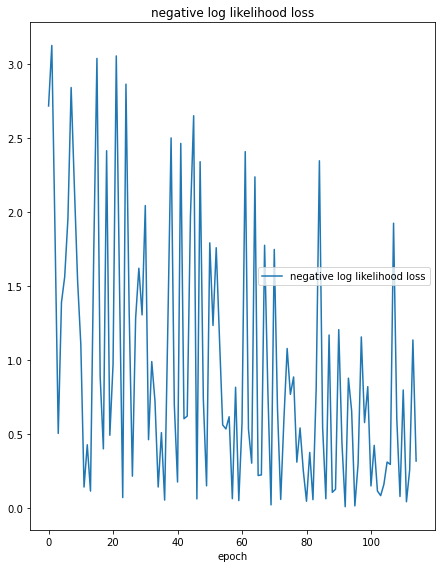

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.007, max:    3.129, cur:    0.316)


In [23]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        tag_scores     = model(encoded_recipe)
        
        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 100 == 0:
            loss_np = loss.detach().numpy()
            liveplot.update({'negative log likelihood loss': loss_np})
            liveplot.draw()
            

Определим уже известную вам функцию "predict_tags". 

In [24]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре

    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

Посмотрим на 10 случайных предложений из тестового датасета — как их будет размечать наша нейросеть. На тренировочных данных матрица ошибок выглядит хорошо. Матрица ошибок, полученная на тестовом датасете, выглядит не так хорошо, как на датасете, на котором мы обучались. Это может быть связано с тем, что, например, в целом, наши датасеты довольно небольшие — это 200 текстов, в каждом по 2000 предложений и, возможно, нам нужно было ещё немного модифицировать функцию потерь, чтобы не так агрессивно взвешивать тэги. Более того, наша нейросеть могла просто переобучиться.  

In [25]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Статистика

##### 1.  Количество верно предсказанных тэгов:

In [26]:
from dlnlputils.sentiment_utils import tag_statistics

In [27]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для Other:
  корректно:	 16177
      всего:	 19922
% корректно:	 81.20168657765284

для B-Whole:
  корректно:	 518
      всего:	 673
% корректно:	 76.96879643387817

для B-Driveability:
  корректно:	 477
      всего:	 1066
% корректно:	 44.746716697936215

для I-Driveability:
  корректно:	 282
      всего:	 711
% корректно:	 39.66244725738397

для B-Appearance:
  корректно:	 145
      всего:	 275
% корректно:	 52.72727272727272

для I-Appearance:
  корректно:	 34
      всего:	 100
% корректно:	 34.0

для B-Reliability:
  корректно:	 326
      всего:	 809
% корректно:	 40.296662546353524

для I-Whole:
  корректно:	 90
      всего:	 213
% корректно:	 42.25352112676056

для B-Comfort:
  корректно:	 596
      всего:	 1067
% корректно:	 55.85754451733833

для I-Comfort:
  корректно:	 186
      всего:	 497
% корректно:	 37.42454728370221

для I-Reliability:
  корректно:	 148
      всего:	 475
% корректно:	 31.157894736842106

для B-Costs:
  корректно:	 

##### 2.  Количество верно предсказанных тэгов в виде матрицы ошибок:

In [28]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, converter, sentence)
    y_true += tags

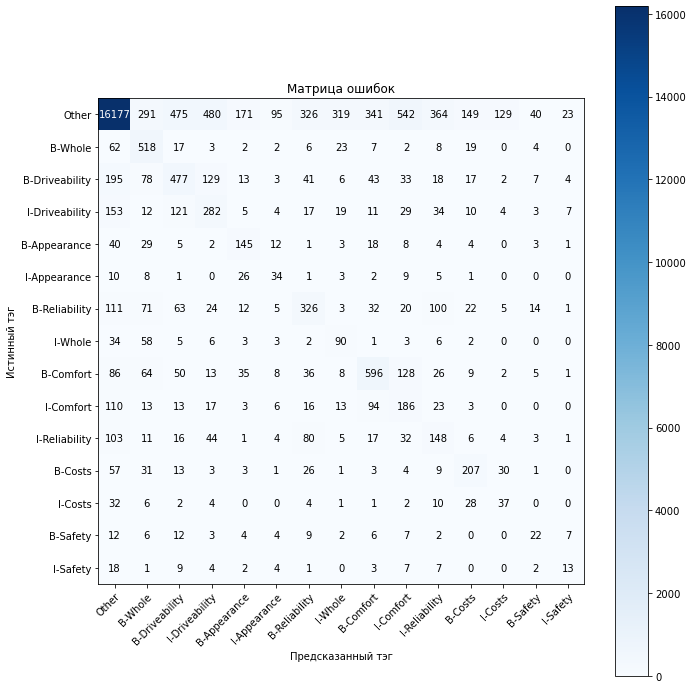

In [29]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

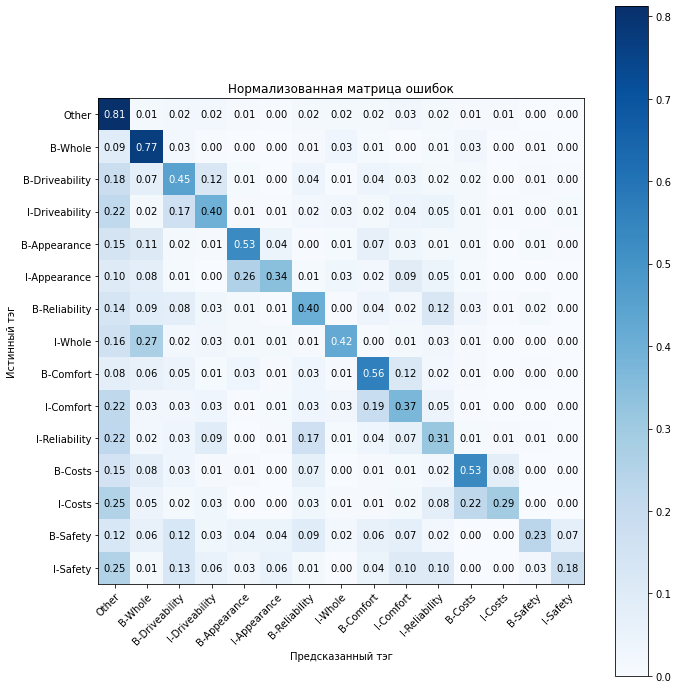

In [30]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()